In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pickle
import random
import itertools
import scipy
from scipy.sparse import csr_matrix, coo_matrix
import statsmodels.api as sm


from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from fuzzywuzzy import fuzz

from lightfm import LightFM
from lightfm.evaluation import auc_score as lightfm_auc_score
from lightfm.evaluation import precision_at_k
from lightfm.cross_validation import random_train_test_split

import implicit

/Users/krisseo/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/krisseo/anaconda3/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


## Load Music Data / Data Collection
***

In [2]:
artname = pd.read_csv('data/usersha1-artmbid-artname-plays.tsv', sep='\t', header=None, names = ['users', 'artist_id', 'artist_name', 'plays'])
profile = pd.read_csv('data/usersha1-profile.tsv', sep='\t', header=None, names = ['users', 'gender', 'age', 'country', 'sign_up'],
                        usecols = ['users', 'country'])


In [3]:
artists_id = pd.Series(artname.artist_name.values,index=artname.artist_id).to_dict()

In [4]:
# To make sure the artist_name is not duplicated by similar names, used mapping from artist name to artist id
# Some of the artists had exact artist_ids but their names were incorrect.
artname.artist_name = artname.artist_id.map(artists_id) 

In [5]:
#Getting all the spotify_data follwing by numbers
filenames = glob.glob('data/spotify_data*.csv')
l = []
for file in filenames: 
    df = pd.read_csv(file)
    l.append(df)
    
spotify_data = pd.concat(l, axis = 0,ignore_index= True)
spotify_data.set_index('trackid', inplace=True)
spotify_data.head()

,artist_name,track_name,pid
trackid,,,
spotify:track:2vCtiBvJJZfz773yTfAxPP,Lost Frequencies,What Is Love 2016 - Mike Mago Remix,3000
spotify:track:5WOLZP8KrXiupBjG1SSN5U,John Legend,Love Me Now - Dave Audé Remix Radio Edit,3000
spotify:track:0oQDQ9QiqsO63EEBAro8Le,July Child,Thinkin of U,3000
spotify:track:7MUS0La2IQ85vJ59fQqtoN,Tiësto,I Will Be Here - (Wolfgang Gartner Remix),3000
spotify:track:3ciyZYofjiqmMUElM5qgGB,Joe Stone,The Party (This Is How We Do It),3000


In [6]:
artists_genres = pickle.load(open("artists_genres.p", 'rb'))
artists_genres.head()

,artist_name,genre
0,Rumer,british singer-songwriter
1,Anita Wilson,contemporary gospel
2,Anita Wilson,gospel
3,Anita Wilson,gospel r&b
4,Matrimony,charlotte nc indie


In [7]:
artists_genres.artist_name = artists_genres.artist_name.str.lower()

In [8]:
bag_of_genres = artists_genres[artists_genres.artist_name.isin(artname.artist_name)]

In [9]:
bag_of_genres.genre = bag_of_genres.genre.astype('category')

In [10]:
len(set(bag_of_genres.genre)) # Total Number of Genres

1843

In [11]:
bag_of_genres = pd.DataFrame(artists_genres.groupby('artist_name')['genre'].agg(lambda x: ', '.join(x)))
print(bag_of_genres.shape) # 16409 Artists
print(bag_of_genres.head())


(16409, 1)
                                                                 genre
artist_name                                                           
!!!                  alternative dance, dance-punk, electronic, fil...
"weird al" yankovic                  antiviral pop, comedy rock, comic
#1 dads                                               australian indie
$teven cannon               dark trap, underground hip hop, vapor trap
$uicideboy$            dark trap, new orleans rap, underground hip hop


In [14]:
all_features = pickle.load(open("all_features.p","rb"))
all_features = all_features.drop(['duration_ms','key','mode','time_signature'], axis=1)


In [15]:
track_features = pd.merge(all_features,spotify_data, left_index=True, right_index=True) # Merging Two dataframes based on their indexes to combine all the information.
track_features = track_features[~track_features.index.duplicated(keep='first')] # Dropping duplicated index.

track_features['artist_name'] = track_features['artist_name'].astype(str).str.lower() # Generalize artist name


I want to use Item-based collaborative filtering by using each song's features as listed below. 
Get similarity scores between one artists music features and all artists' the user listened.


In [16]:
track_features.info() # 93132 all non-null values. No Missing values.
track_features.sort_values(['artist_name','track_name'],inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 93132 entries, spotify:track:000VZqvXwT0YNqKk7iG2GS to spotify:track:7zzLt6Z9y7jMvXnEg00n58
Data columns (total 13 columns):
acousticness        93132 non-null float64
danceability        93132 non-null float64
energy              93132 non-null float64
instrumentalness    93132 non-null float64
liveness            93132 non-null float64
loudness            93132 non-null float64
speechiness         93132 non-null float64
tempo               93132 non-null float64
valence             93132 non-null float64
popularity          93132 non-null int64
artist_name         93132 non-null object
track_name          93132 non-null object
pid                 93132 non-null int64
dtypes: float64(9), int64(2), object(2)
memory usage: 9.9+ MB


## EDA

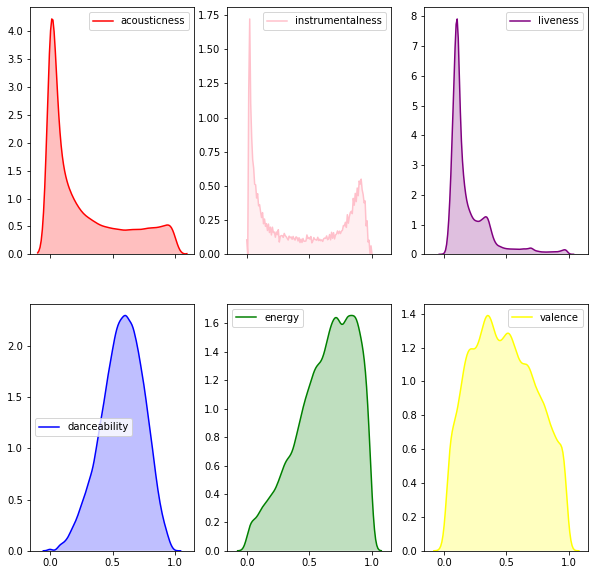

In [15]:
f, axes = plt.subplots(2, 3,figsize=(10, 10), sharex=True)
sns.kdeplot(track_features.acousticness, shade=True, color='red', ax=axes[0, 0])
sns.kdeplot(track_features.instrumentalness, shade=True, color="pink", ax=axes[0, 1])
sns.kdeplot(track_features.liveness, shade=True, color='purple', ax=axes[0, 2])
sns.kdeplot(track_features.danceability, shade=True, color="blue", ax=axes[1, 0])
sns.kdeplot(track_features.energy, shade=True, color="green", ax=axes[1, 1])
sns.kdeplot(track_features.valence, shade=True, color='yellow', ax=axes[1, 2])


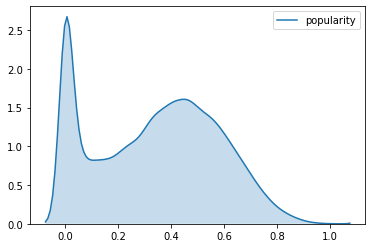

In [16]:
#sns.kdeplot(merged.loudness, shade=True, color='yellow')
sns.kdeplot(track_features.popularity.divide(max(track_features.popularity)), shade=True)

In [17]:
def heatMap(df):
    """ Taking a dataframe and returns to Heat Map to describe 
        each of features in the df.
    """
    corr = df.corr()
    # Return Upper Triangular Correlation Matrix, since corr matrix is symmetric.
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set Figures
    fig, ax = plt.subplots(figsize=(10, 10))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    # Generate Heat Map based on Correlation
    sns.heatmap(corr, mask=mask, cmap=colormap, annot=True, fmt=".2f")
    
    # Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    # Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    # Show plot
    plt.show()

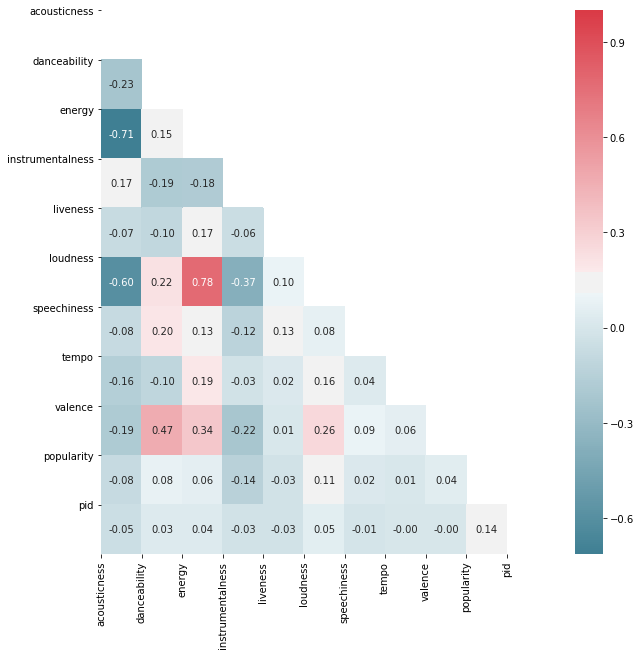

In [18]:
heatMap(track_features)

# Data Cleaning

In [19]:
track_features.describe()
# When you look at loudness, the minimum is -60 db, which people cannot hear well. We can treat them as an outlier.
# There are some outliers in this data.
track_features.drop(columns='pid',inplace=True)

In [20]:
track_features[track_features.loudness == -60]
# Most of these data's values are minimum and can be trated as Missing Value.
# Remove these missing values
track_features = track_features[~(track_features.loudness == min(track_features.loudness))]
track_features.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
count,93124.000000,93124.000000,93124.000000,93124.000000,93124.000000,93124.000000,93124.000000,93124.000000,93124.000000,93124.000000
mean,0.273715,0.576644,0.632411,0.103791,0.200468,-7.868746,0.088602,121.527455,0.478914,29.579238
std,0.308158,0.167865,0.232862,0.252942,0.173219,4.272052,0.100403,29.234510,0.250132,20.237029
min,0.000000,0.000000,0.000000,0.000000,0.000000,-44.749000,0.000000,0.000000,0.000000,0.000000
25%,0.018900,0.467000,0.478000,0.000000,0.096200,-9.494000,0.034800,98.883000,0.276000,11.000000
50%,0.131000,0.586000,0.668000,0.000018,0.128000,-6.849000,0.047900,120.838500,0.467000,31.000000
75%,0.477000,0.699000,0.821000,0.008180,0.255000,-5.063750,0.090900,139.978000,0.676000,45.000000
max,0.996000,0.991000,1.000000,0.999000,1.000000,2.766000,0.965000,232.690000,1.000000,87.000000


In [22]:
len(track_features[track_features.popularity == min(track_features.popularity)])
# 11845 songs are not listened by regular users.

11845

In [23]:
print(track_features.popularity.quantile(np.arange(.9,1,.01)))
pop_threshold = 40 # Want to gather more data ,since our maximum of popularity is 87
track_features_popular = track_features.query('popularity >= @pop_threshold')
len(track_features_popular)

0.90    56.0
0.91    57.0
0.92    58.0
0.93    59.0
0.94    60.0
0.95    61.0
0.96    63.0
0.97    65.0
0.98    67.0
0.99    71.0
Name: popularity, dtype: float64


32952

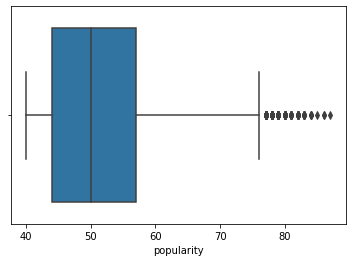

In [24]:
sns.boxplot(x=track_features_popular.popularity, data=track_features_popular)

## Content Based Recommendation System by Spotify's Audio Features
Content based recommendation system compares each track's features to calculate the similarity of them.

$similarity = cos(\ \theta ) = \ \dfrac{\ \boldsymbol{u} \ \cdot \ \boldsymbol{v}}{\ \|{\ \boldsymbol{u}}\ \|\ \|{\ \boldsymbol{v}}\ \|}$
This is basically same as normalized vector u times normalized vector v.

In [25]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'loudness','speechiness','tempo','valence']
# Separating out the features
x = track_features_popular.loc[:, features]
x = StandardScaler().fit_transform(x) # Normalized all features to have mean of 0 and sd of 1.
 
sim = pd.DataFrame(cosine_similarity(x), index=track_features_popular.index)
sim.columns = track_features_popular.index
indices = pd.Series(track_features_popular.index)
indices[:5]

0    spotify:track:7y8aVfDkqt6qirGNivvs0M
1    spotify:track:32TXsOUIWtTQDkE72Cvafe
2    spotify:track:3MZ0Obyv6AnO1anmGBJydv
3    spotify:track:5r96TaQquRrlo3Ym3ZlSL2
4    spotify:track:1gloYGAZI6eHp6MEPjLuL3
dtype: object

In [26]:
sim = (sim + 1) / 2
sim.head() # Shows how each songs are similar to each other in range of (0,1)

,spotify:track:7y8aVfDkqt6qirGNivvs0M,spotify:track:32TXsOUIWtTQDkE72Cvafe,spotify:track:3MZ0Obyv6AnO1anmGBJydv,spotify:track:5r96TaQquRrlo3Ym3ZlSL2,spotify:track:1gloYGAZI6eHp6MEPjLuL3,spotify:track:2Q26sym8OSOl6PfH7LLPtJ,spotify:track:74sUbOF9Zm8LdGUJjxleTl,spotify:track:60R2v9lheAu3lwZwAFxMZK,spotify:track:4qbWToFOFOmFrBVClOidKn,spotify:track:7ahhev2IIbivmkRqLjm7g3,...,spotify:track:194uD6fRM58ztn7Z1Mfyr2,spotify:track:2qq5HTgeJTLL9oY7b4X16y,spotify:track:6J5mJPOs8EGCyjljxeLYx5,spotify:track:70jK4YYMql3lJFBUK6l8QT,spotify:track:6BuGA3ontF6D4jluQ0DHZY,spotify:track:5XfHNrdomVBNxUI0iRztic,spotify:track:5oOYmBhKeMtweW5EwwZhVg,spotify:track:1yeMCWXg3gdbQcIsXwnTiO,spotify:track:0dT2JHN6fGZnwhNxTcDJRk,spotify:track:6YepaCG8cUabGz3lyCgCxv
spotify:track:7y8aVfDkqt6qirGNivvs0M,1.000000,0.836905,0.362250,0.492136,0.738715,0.783576,0.312570,0.704688,0.254312,0.395002,...,0.240525,0.700079,0.587486,0.175145,0.379578,0.834269,0.942049,0.788789,0.585406,0.180126
spotify:track:32TXsOUIWtTQDkE72Cvafe,0.836905,1.000000,0.490749,0.538665,0.682906,0.759654,0.319757,0.465849,0.285849,0.235925,...,0.219436,0.500692,0.521127,0.373146,0.640106,0.511442,0.844804,0.525665,0.478739,0.250496
spotify:track:3MZ0Obyv6AnO1anmGBJydv,0.362250,0.490749,1.000000,0.619315,0.510802,0.460363,0.402927,0.599227,0.493930,0.253876,...,0.498646,0.682951,0.698045,0.698377,0.737207,0.463594,0.410863,0.322758,0.436593,0.492909
spotify:track:5r96TaQquRrlo3Ym3ZlSL2,0.492136,0.538665,0.619315,1.000000,0.331344,0.600916,0.405685,0.585449,0.176991,0.436495,...,0.291022,0.394653,0.282489,0.529756,0.574430,0.487810,0.575064,0.553333,0.151020,0.629760
spotify:track:1gloYGAZI6eHp6MEPjLuL3,0.738715,0.682906,0.510802,0.331344,1.000000,0.745554,0.695594,0.757495,0.698610,0.143345,...,0.621134,0.767972,0.782463,0.355662,0.382835,0.634430,0.770528,0.352641,0.847329,0.303749


In [27]:
similar_items = pd.DataFrame(sim.loc['spotify:track:0tgVpDi06FyKpA1z0VMD4v'])
similar_items.columns = ["similarity_score"]
similar_items = similar_items.sort_values('similarity_score', ascending=False)
similar_items = similar_items[1:10] # Except the song itself which has a similarity score of 1.
similar_items.reset_index(inplace=True)
similar_items = similar_items.rename(index=str, columns={"index": "item_id"},)
similar_items

,item_id,similarity_score
0,spotify:track:6h0hBlyQGZeR8mb6SpX2us,0.985965
1,spotify:track:3DkaXDmC0qaFNAxgLMuwX4,0.981521
2,spotify:track:5P3yUXUC9rZPJPNmYGKEAz,0.980976
3,spotify:track:6J0xeqjdpsUH0W1YBCmD1L,0.979802
4,spotify:track:0tkBOcK7oRVXQJY97zzSvr,0.979772
5,spotify:track:44XXnLW9z7YZXSHIUVj4cO,0.978736
6,spotify:track:4aXAuEMP6QP3f2vYjrrXle,0.977824
7,spotify:track:66QtMlymqBC5O1F3fh5wTZ,0.975659
8,spotify:track:6rjtB7KSIiJ6v9vrACMlqF,0.973101


In [28]:
def get_track_index(track_name):
    return track_features_popular[track_features_popular.track_name == track_name].index.values[0]

def get_track_name(track_index):
    return track_features_popular.loc[track_index].track_name

def get_artist_name(track_name):
    return track_features_popular[track_features_popular.track_name == track_name].artist_name[0]

In [29]:
def content_recommendations(track_name, cosine_sim = sim.values):
    """
    parameters:
    
    track_name - track_name to get recommended
    
    cosine_sim - similar values of track_features has to be pivoted matrix.
    
    """
    recommended_songs = []
    spotify_id = get_track_index(track_name)
    # gettin the index of the track that matches the uri
    idx = indices[indices == spotify_id].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar tracks
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    
    for i in top_10_indexes:
        recommended_songs.append(list(track_features_popular.index)[i])
    
    top_10_artists = track_features_popular[track_features_popular.index.isin(recommended_songs)]
    top_10_artists['scores'] = list(score_series.iloc[1:11,])
    top_10_artists.reset_index(inplace=True)
    print('Recommendation of {0} by the artist "{1}"'.format(track_name,get_artist_name(track_name)))
    for i in range(0,len(top_10_artists)):
         print ('{0}: {1} by the artist "{2}", with scores of {3:.3f}'.format(i+1,top_10_artists.track_name[i],\
                                                                           top_10_artists.artist_name[i], top_10_artists.scores[i]))
    
    return None



In [30]:
content_recommendations('Perfect')

Recommendation of Perfect by the artist "ed sheeran"
1: Telescope by the artist "cage the elephant", with scores of 0.986
2: Little Bit by the artist "chris brown", with scores of 0.982
3: It Ain't Wrong Loving You by the artist "honne", with scores of 0.981
4: Cry by the artist "k. michelle", with scores of 0.980
5: 400 Lux by the artist "lorde", with scores of 0.980
6: Nebraska - Radio Edit by the artist "lucy rose", with scores of 0.979
7: Monster by the artist "meg myers", with scores of 0.978
8: Dontchange - Album Version (Edited) by the artist "musiq soulchild", with scores of 0.976
9: Goner by the artist "twenty one pilots", with scores of 0.973
10: Take on the World by the artist "you me at six", with scores of 0.972


In [31]:
content_recommendations('Hey Jude')

Recommendation of Hey Jude by the artist "wilson pickett"
1: Mornin' by the artist "al jarreau", with scores of 0.991
2: I'm Eighteen by the artist "alice cooper", with scores of 0.990
3: Ocean Front Property by the artist "george strait", with scores of 0.985
4: Cheap Day Return by the artist "jethro tull", with scores of 0.984
5: Love Will Turn You Around by the artist "kenny rogers", with scores of 0.982
6: I Think I ll Just Stay Here And Drink by the artist "merle haggard", with scores of 0.982
7: The Pusher by the artist "steppenwolf", with scores of 0.981
8: Golden Brown by the artist "the stranglers", with scores of 0.981
9: Sweet Thing by the artist "van morrison", with scores of 0.978
10: T. B. Sheets by the artist "van morrison", with scores of 0.975


In [32]:
content_recommendations('L$D')

Recommendation of L$D by the artist "a$ap rocky"
1: Nothing's Gonna Hurt You Baby by the artist "cigarettes after sex", with scores of 0.983
2: Late Night by the artist "foals", with scores of 0.977
3: Game over! by the artist "harris cole", with scores of 0.977
4: Oceans (Where Feet My Fail) - Live/Acoustic Version by the artist "hillsong united", with scores of 0.977
5: You've Been Missed by the artist "partynextdoor", with scores of 0.976
6: Indian Reservation (The Lament of the Cherokee Reservation Indian) by the artist "paul revere & the raiders", with scores of 0.976
7: Hey You by the artist "pink floyd", with scores of 0.972
8: Mother by the artist "pink floyd", with scores of 0.970
9: Howling by the artist "ry x", with scores of 0.970
10: Neptune by the artist "sleeping at last", with scores of 0.969


## Content Based Recommendation System by song's genres from spotify and last fm.
## Informational Retrieval (TF-Idf)

In [33]:
bag_of_genres.head()

,genre
artist_name,
!!!,"alternative dance, dance-punk, electronic, fil..."
"""weird al"" yankovic","antiviral pop, comedy rock, comic"
#1 dads,australian indie
$teven cannon,"dark trap, underground hip hop, vapor trap"
$uicideboy$,"dark trap, new orleans rap, underground hip hop"


In [95]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
x = tfidf.fit_transform(bag_of_genres['genre'])
# Compute the cosine similarity matrix of genres
tfidf_cosine_sim = cosine_similarity(x, x)


In [96]:
x.shape # 16409 Artists with 1257 different genres


(16409, 1257)

In [101]:
count = CountVectorizer(stop_words='english',ngram_range=(1,1)) # Initializing for counting genres.
count_matrix = count.fit_transform(bag_of_genres['genre']) # Transform
count_cosine_sim = cosine_similarity(count_matrix, count_matrix)


In [38]:
genre_indices = pd.Series(bag_of_genres.index)
genre_indices[:5]

0                    !!!
1    "weird al" yankovic
2                #1 dads
3          $teven cannon
4            $uicideboy$
Name: artist_name, dtype: object

In [39]:
def content_recommendations_genre(artist_name, cosine_sim):
    
    recommended_songs = []
    ratio_tuples = []
    query_idx = None
    # Use fuzz ratio since some of the artist names are ambiguous or commonly used with specific symbols
    # for instances $ is used for S.
    
    for i in bag_of_genres.index:
        ratio = fuzz.ratio(i.lower(), artist_name.lower())
        if ratio >= 80:
            current_query_idx = bag_of_genres.index.tolist().index(i) # Getting the index of current query
            ratio_tuples.append((i, ratio, current_query_idx))
    print('Possible matches: {0}\n'.format([(x[0], x[1]) for x in ratio_tuples]))
    try:
        artist = max(ratio_tuples, key=lambda x: x[1])[0] # get the name of the artist with the highest fuzz ratio
    except:
        print("You artists didn't match any of artists in the data. Try again")
        return None

    # Find the index of the artist that matches
    query_idx = genre_indices[genre_indices == artist].index[0]
    print('Recommendations for {0}:\n'.format(artist))
    
    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[query_idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_songs.append(list(bag_of_genres.index)[i])
    
    top_10_artists = bag_of_genres[bag_of_genres.index.isin(recommended_songs)]
    top_10_artists['scores'] = list(score_series.iloc[1:11,])
    top_10_artists.reset_index(inplace=True)
    for i in range(0,len(top_10_artists)):
         print ('{0}: {1}, with scores of {2:.3f}'.format(i+1, top_10_artists.artist_name[i], top_10_artists.scores[i]))
    return None

In [93]:
content_recommendations_genre('The Beatles',count_cosine_sim)

Possible matches: [('re beatles', 86), ('the antlers', 82), ('the bangles', 82), ('the beat', 84), ('the beatangers', 80), ('the beatles', 100)]

Recommendations for the beatles:

1: procol harum, with scores of 0.815
2: the animals, with scores of 0.810
3: the hollies, with scores of 0.794
4: the kinks, with scores of 0.786
5: the pretty things, with scores of 0.781
6: the rolling stones, with scores of 0.778
7: the spencer davis group, with scores of 0.766
8: the troggs, with scores of 0.761
9: the yardbirds, with scores of 0.756
10: them, with scores of 0.756


In [105]:
content_recommendations_genre('The Beatles', tfidf_cosine_sim)

Possible matches: [('re beatles', 86), ('the antlers', 82), ('the bangles', 82), ('the beat', 84), ('the beatangers', 80), ('the beatles', 100)]

Recommendations for the beatles:

1: chad & jeremy, with scores of 0.841
2: georgie fame & the blue flames, with scores of 0.698
3: marianne faithfull, with scores of 0.691
4: the hollies, with scores of 0.681
5: the nashville teens, with scores of 0.680
6: the spencer davis group, with scores of 0.653
7: the troggs, with scores of 0.650
8: the yardbirds, with scores of 0.650
9: them, with scores of 0.633
10: unit 4 + 2, with scores of 0.632


In [44]:
content_recommendations_genre('A$AP Rocky',count_cosine_sim)

Possible matches: [('a$ap rocky', 100)]

Recommendations for a$ap rocky:

1: 2 chainz, with scores of 0.951
2: a$ap ferg, with scores of 0.951
3: big sean, with scores of 0.951
4: cam’ron, with scores of 0.951
5: dj khaled, with scores of 0.951
6: future, with scores of 0.951
7: mike will made-it, with scores of 0.951
8: quavo, with scores of 0.951
9: schoolboy q, with scores of 0.951
10: tory lanez, with scores of 0.951


In [42]:
content_recommendations_genre('ASAP Rocky', tfidf_cosine_sim)

Possible matches: [('a$ap rocky', 90), ('aesop rock', 80)]

Recommendations for a$ap rocky:

1: big pun, with scores of 0.910
2: cam’ron, with scores of 0.908
3: dmx, with scores of 0.904
4: fat joe, with scores of 0.904
5: french montana, with scores of 0.904
6: memphis bleek, with scores of 0.898
7: method man, with scores of 0.898
8: pnb rock, with scores of 0.897
9: rae sremmurd, with scores of 0.897
10: the lox, with scores of 0.897


In [43]:
content_recommendations_genre('A$AP Rocky',tfidf_cosine_sim)

Possible matches: [('a$ap rocky', 100)]

Recommendations for a$ap rocky:

1: big pun, with scores of 0.910
2: cam’ron, with scores of 0.908
3: dmx, with scores of 0.904
4: fat joe, with scores of 0.904
5: french montana, with scores of 0.904
6: memphis bleek, with scores of 0.898
7: method man, with scores of 0.898
8: pnb rock, with scores of 0.897
9: rae sremmurd, with scores of 0.897
10: the lox, with scores of 0.897


the most frequently used words in a document are often the most frequently used words in all of the documents. In contrast, terms with the highest tf-idf scores are the terms in a document that are distinctively frequent in a document, when that document is compared other documents.



# Stastistical Inference

In [98]:
rocky = track_features_popular[track_features_popular.artist_name == 'a$ap rocky']
rocky.mean()

acousticness          0.197358
danceability          0.626469
energy                0.654344
instrumentalness      0.056744
liveness              0.283734
loudness             -7.614031
speechiness           0.202637
tempo               119.673781
valence               0.413762
popularity           60.375000
dtype: float64

In [99]:
ferg = track_features_popular[track_features_popular.artist_name == 'a$ap ferg']

In [100]:
quavo = track_features_popular[track_features_popular.artist_name == 'quavo']

In [101]:
park = track_features_popular[track_features_popular.artist_name == 'linkin park']
park.mean()


acousticness          0.070211
danceability          0.560500
energy                0.864680
instrumentalness      0.016378
liveness              0.250596
loudness             -4.935780
speechiness           0.093098
tempo               121.625400
valence               0.479798
popularity           59.160000
dtype: float64

In [102]:
# Assumption is that rocky's song features and ferg's features are different from each other.
# p-value is .95 --> Fail to reject the null hypothesis.
from scipy.stats import ttest_ind
scipy.stats.ttest_ind(rocky.mean(),park.mean())

Ttest_indResult(statistic=-0.01812379768562407, pvalue=0.9857394789213656)

### Users Data In United States

#### We have an implicit data of users, which is counting of their music plays and this implict data can indicate users' preference of their artists.
Users don't care about the ability of predictions from the recommender system; they just want to see things they are likely to love.


In [25]:
artname = artname.set_index('users')
profile = profile.set_index('users')

In [26]:
profile_merged = pd.merge(artname,profile, left_index=True, right_index=True)
profile_merged = profile_merged.reset_index()
profile_merged[['users','artist_name']] = profile_merged[['users','artist_name']].astype('category')
us_profile = profile_merged[profile_merged.country == 'United States'].drop(['country'],axis=1) # We will recommend artists for users in United States

In [27]:
# Now before train the data, lets see which artists are in common in merged_popular
bag_of_genres_artists = set(bag_of_genres.index)
lastfm_artists = set(us_profile.artist_name)
len(lastfm_artists.intersection(bag_of_genres_artists)) # Artists are in common for both dataframes.

7510

In [28]:
artists_common = lastfm_artists.intersection(bag_of_genres_artists)
merged_last = us_profile[us_profile.artist_name.isin(artists_common)] # Contains all artists in both dataframes.


In [29]:
# Shows there is no more duplicated rows in the data frame.
has_nan = merged_last.isnull().any(axis=0)
has_nan = [merged_last.columns[i] for i in np.where(has_nan)[0]]
print(has_nan) 

[]


In [30]:
artists_plays = merged_last.groupby(['artist_id'])['plays'].sum().reset_index()
artists_plays.columns = ['artist_id','total plays']
artists_plays.head()

,artist_id,total plays
0,0002f649-8285-4a72-b847-b3854e1a449c,20882
1,00034ede-a1f1-4219-be39-02f36853373e,4010
2,000fc734-b7e1-4a01-92d1-f544261b43f5,515795
3,000fecd9-ae03-49bc-9a08-636dde5d405d,27855
4,0017114a-a0bc-4af9-83d1-75f7a506c3f0,145


In [113]:
artists_plays['total plays'].describe()

count    7.590000e+03
mean     8.042334e+04
std      2.913556e+05
min      1.000000e+00
25%      1.014000e+03
50%      6.900000e+03
75%      4.209400e+04
max      1.070638e+07
Name: total plays, dtype: float64

In [114]:
us_profile['plays'].describe()

count    3.336272e+06
mean     2.555277e+02
std      7.066286e+02
min      1.000000e+00
25%      4.700000e+01
50%      1.180000e+02
75%      2.660000e+02
max      2.883750e+05
Name: plays, dtype: float64

Minimum of total plays is one, which can be interpreted as there are not well known unique artists.
Need to clean the data. 
Difference of min and max is too big for total plays and median of total plays is 1.24e4; therefore, I have to set up a reasonable threshold to prevent nosiy data.
Also, for each user's plays, I will set up a threshold to prevent the noise.

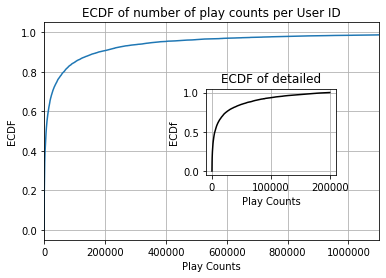

In [115]:
y = np.sort(artists_plays['total plays'])
yvals = np.arange(len(y))/float(len(y))

y_detailed = y[y<200000]
yvals_detailed = np.arange(len(y_detailed))/float(len(y_detailed))
plt.plot (y, yvals)
plt.xlabel('Play Counts')
plt.xlim(0,1100000)
plt.ylabel('ECDF')
plt.title('ECDF of number of play counts per User ID')
plt.grid(True,which="both",ls="-")

sub_axes = plt.axes([.5, 0.35, .3, .3]) 
sub_axes.plot(y_detailed,yvals_detailed, c = 'k') 
plt.xlabel('Play Counts')
plt.ylabel('ECDf')
plt.title('ECDF of detailed')
plt.grid(True,which="both",ls="-")
plt.show()


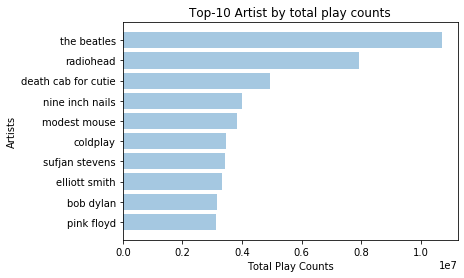

In [116]:
sorted_total = artists_plays.sort_values(by='total plays', ascending=False)[:10]
top_10 = [merged_last[merged_last.artist_id == top]['artist_name'][0] for top in sorted_total.artist_id]
y_pos = range(len(sorted_total))
frequency = sorted_total['total plays']

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, top_10[::-1])
plt.xlabel('Total Play Counts')
plt.ylabel('Artists')
plt.title('Top-10 Artist by total play counts')
plt.show()


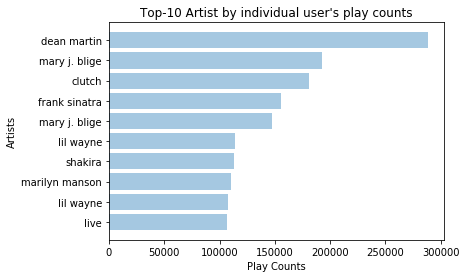

In [117]:
sorted_plays = merged_last[['artist_name','plays']].sort_values(by='plays', ascending=False)[:10]
frequency = sorted_plays['plays']
y_pos = range(len(sorted_plays))

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, sorted_plays['artist_name'][::-1])
plt.xlabel('Play Counts')
plt.ylabel('Artists')
plt.title("Top-10 Artist by individual user's play counts")
plt.show()

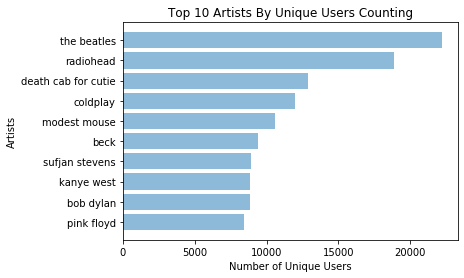

In [31]:
artist_by_total = merged_last.groupby('artist_name').agg({'users':'count'}).rename(columns={'users':'total_unique_users'})
artist_by_total.sort_values(by='total_unique_users', ascending=False, inplace=True)
artists10 = artist_by_total[0:10]
y_pos = np.arange(len(artist_by_total[0:10]))
artists = artist_by_total[0:10].index.tolist()

plt.barh(y_pos, artists10.total_unique_users[::-1], align='center', alpha=0.5)
plt.yticks(y_pos, artists[::-1])
plt.xlabel('Number of Unique Users')
plt.ylabel('Artists')
plt.title('Top 10 Artists By Unique Users Counting')

plt.show()

In [32]:
users_with_total = merged_last.merge(artists_plays, on='artist_id', how='left')
users_with_total = users_with_total.merge(artist_by_total, on='artist_name', how='left')
users_with_total.isnull().sum()
# Dropping Missing values of artist_id
users_with_total = users_with_total[~users_with_total.artist_id.isnull()] 
# Dropping 33 Missing values of artist names
users_with_total = users_with_total[~users_with_total.artist_name.isnull()] 
users_with_total.drop(columns=['artist_id'], inplace=True)
users_with_total.users = users_with_total.users.cat.codes# Change it to categorical code to summarize user Ids


In [33]:
users_with_total.isnull().sum() #No more missing values are detected.

users                 0
artist_name           0
plays                 0
total plays           0
total_unique_users    0
dtype: int64

[Text(0.5, 0, '')]

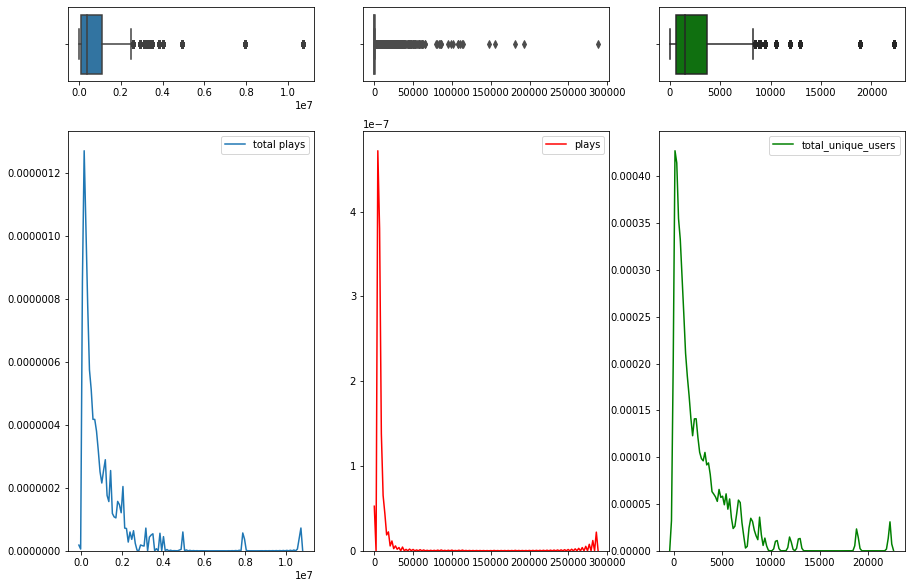

In [34]:
f, axes = plt.subplots(nrows=2, ncols=3,figsize=(15, 10),gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(users_with_total['total plays'], ax=axes[0,0])
sns.kdeplot(users_with_total['total plays'], ax=axes[1,0])
axes[0,0].set(xlabel='')

sns.boxplot(users_with_total.plays, ax=axes[0,1], color='red')
sns.kdeplot(users_with_total.plays, ax=axes[1,1], color='red')
axes[0,1].set(xlabel='')

sns.boxplot(users_with_total.total_unique_users, ax=axes[0,2], color='green')
sns.kdeplot(users_with_total.total_unique_users, ax=axes[1,2], color='green')
axes[0,2].set(xlabel='')

[Text(0, 0.5, 'Density'), Text(0.5, 0, 'Log10 (# of total unique users)')]

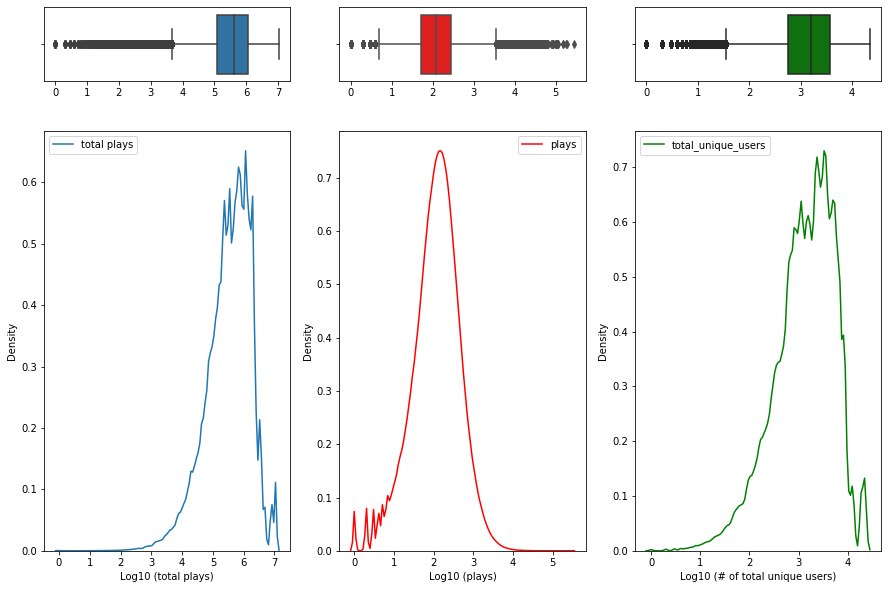

In [35]:
f, axes = plt.subplots(nrows=2, ncols=3,figsize=(15, 10),gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(np.log10(users_with_total['total plays']), ax=axes[0,0])
sns.kdeplot(np.log10(users_with_total['total plays']), ax=axes[1,0])
axes[0,0].set(xlabel='')
axes[1,0].set(xlabel='Log10 (total plays)',ylabel='Density')

sns.boxplot(np.log10(users_with_total.plays), ax=axes[0,1], color='red')
sns.kdeplot(np.log10(users_with_total.plays), ax=axes[1,1], color='red')
axes[0,1].set(xlabel='')
axes[1,1].set(xlabel='Log10 (plays)',ylabel='Density')

sns.boxplot(np.log10(users_with_total.total_unique_users), ax=axes[0,2], color='green')
sns.kdeplot(np.log10(users_with_total.total_unique_users), ax=axes[1,2], color='green')
axes[0,2].set(xlabel='')
axes[1,2].set(xlabel='Log10 (# of total unique users)', ylabel='Density')

We can see all of distributions have long tails and are exponential.
Will try to use the long tails since items in long tail are the items cater to people with unique niche interesets.
Long tails are actually driving a significant volume of users.
Transformed to log normal for plays to see the plays distribution clearly.

In [36]:
# Set the threshold to prevent the noise.
total_threshold = artists_plays['total plays'].quantile(.3)
plays_threshold = users_with_total.plays.quantile(.3)
users_threshold = 50

In [37]:
cleaned = users_with_total[users_with_total.plays >= plays_threshold]
cleaned = cleaned[cleaned.total_unique_users >= users_threshold]
cleaned = cleaned[cleaned['total plays'] >= total_threshold]

#users_with_total.artist_name = users_with_total.artist_name.cat.codes

In [38]:
cleaned.head()

,users,artist_name,plays,total plays,total_unique_users
0,4,devendra banhart,456,868311,2989
1,4,boards of canada,407,1750033,4314
2,4,cocorosie,386,382582,1434
3,4,aphex twin,213,1093663,3701
4,4,animal collective,203,1808594,5740


In [124]:
len(set(cleaned.users)),len(set(cleaned.artist_name)) # 61340 users, 3647 artists

(61340, 3647)

# General Collaborative Based Filtering Item(Artists) Based

In [125]:
artists_users_pivoted = cleaned.pivot_table(index='artist_name', columns='users', values='plays').fillna(0)
artists_users_sparse = csr_matrix(artists_users_pivoted.values)
artists_users_sparse # 61340 users and 3647 artists

<3647x61340 sparse matrix of type '<class 'numpy.float64'>'
	with 1576182 stored elements in Compressed Sparse Row format>

In [126]:
model_knn = NearestNeighbors(metric='cosine',algorithm = 'brute')
model_knn.fit(artists_users_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [127]:
query_index = np.random.choice(artists_users_pivoted.shape[0])
distances, indices = model_knn.kneighbors(artists_users_pivoted.iloc[query_index].values.reshape(1, -1), 
                                          n_neighbors = 6)


for i in range(0, len(distances.flatten())):
    if i == 0:
        print ('Similar Artists for {0}:\n'.format(artists_users_pivoted.index[query_index]))
    else:
        print ('{0}: {1}, with distance of {2:.3f}:'.format(i, artists_users_pivoted.index[indices.flatten()[i]], distances.flatten()[i]))

Similar Artists for brad paisley:

1: alan jackson, with distance of 0.533:
2: tim mcgraw, with distance of 0.554:
3: keith urban, with distance of 0.566:
4: kenny chesney, with distance of 0.593:
5: toby keith, with distance of 0.607:


## Co-occurence Matrix (Item vs Item)

In [59]:
def get_artist_users(artists):
    """ 
    Get unique users who listened the "artists"
    """
    artist_data = cleaned[cleaned.artist_name == artists]
    artist_users = set(artist_data.users.unique())
    return artist_users
#get_artist_users('lady gaga')


In [60]:
def get_users_artists(users):
    """ 
    users: users' category codes (integer)
    
    Get unique artists played by the users
    """
    users_data = cleaned[cleaned.users == users]
    users_artists = users_data[['artist_name','plays']]
    return users_artists

In [39]:
cleaned['played'] = cleaned.plays.apply(np.sign) # 1 indicates a user played an artist,but 0 indicates a user didn't

In [40]:
binary_users_artists_pivoted = cleaned.pivot_table(index='users', columns='artist_name', values='played').fillna(0).astype(int)
binary_users_artists_sparse = csr_matrix(binary_users_artists_pivoted.values)

In [41]:
binary_users_artists_sparse.shape 

(61340, 3647)

In [42]:
binary_users_artists_sparse.toarray()[0].nonzero() # The user index with 0 played artists with indices... and so on.

(array([  63,   71,  128,  152,  171,  178,  183,  221,  231,  289,  317,
         328,  420,  491,  492,  499,  562,  680,  869, 1014, 1026, 1172,
        1297, 1478, 2008, 2072, 2094, 2134, 2248, 2279, 2428, 2478, 2488,
        2535, 2673, 2955, 3072, 3158, 3234, 3545, 3587]),)

In [43]:
co_occ = binary_users_artists_sparse.T.dot(binary_users_artists_sparse)
co_occ.setdiag(0)
co_occ.toarray() # Showing the co-occurence matrix of artists. 2341 x 2341.

array([[0, 0, 3, ..., 0, 2, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [55]:
demo = pd.DataFrame(co_occ.A, index=binary_users_artists_pivoted.columns, columns=binary_users_artists_pivoted.columns).head()
demo

artist_name,!!!,'til tuesday,*nsync,+44,...and you will know us by the trail of dead,10 ft. ganja plant,10 years,"10,000 maniacs",10cc,112,...,z-ro,zap mama,zebrahead,zero 7,ziggy marley,zion i,zomby,zox,zz top,µ-ziq
artist_name,,,,,,,,,,,,,,,,,,,,,
!!!,0,0,3,1,20,1,0,0,0,0,...,0,0,2,13,0,0,1,0,2,2
'til tuesday,0,0,0,0,1,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
*nsync,3,0,0,14,1,0,3,0,0,12,...,0,0,2,6,0,0,0,0,0,0
+44,1,0,14,0,2,0,5,1,0,0,...,0,0,4,0,0,0,0,1,0,0
...and you will know us by the trail of dead,20,1,1,2,0,1,4,0,0,0,...,0,1,1,7,0,2,0,0,1,1


In [57]:
#random_query = np.random.choice(co_occ.shape[0])
def collab_n_rec_artists(co_occ, data ,query, n=10):
        """
        parameters:
        
        co_occ - co-occurence of a matrix, (len (artists) * len (artists)), values of users played or not (1|0)
        user_artists: List of artists that the user listened
        
        data -  pivoted matrix with index = 'users', columns = 'artist_name' and values = 'played'
        
        query - query of user ids
        
        returns:
        Based on similarity of user's artists and all unique artists, recommend artists.
        
        """
        user_name = binary_users_artists_pivoted.index[query]
        print('History of User {0} loading :\n'.format(user_name))
        history = get_users_artists(user_name).head(n)
        for i in range(0,len(history)):
            print("{0}: '{1}' was played {2} times".format(i+1, history.iloc[i][0], history.iloc[i][1]))
        print('\n')
        rec_vec = co_occ[np.where(data.iloc[random_query] > 0)].A.sum(axis=0) # Get recommended vector based on co_occurence of artists matrix
        rec_vec = rec_vec * (1-data.iloc[random_query]) # Set listened artists as zero to avoid recommending the same artist. 
        rec_artists = rec_vec.sort_values(ascending=False)[0:n]
        print ('Recommendations for  user {0}:\n'.format(user_name))
        for i in range(0,len(rec_artists)):
            print ("{0}: '{1}', with # of similar users {2}".format(i+1, rec_artists.index[i], rec_artists.values[i]))
        

In [61]:
collab_n_rec_artists(co_occ,binary_users_artists_pivoted, query=0, n=10)

History of User 4 loading :

1: 'devendra banhart' was played 456 times
2: 'boards of canada' was played 407 times
3: 'cocorosie' was played 386 times
4: 'aphex twin' was played 213 times
5: 'animal collective' was played 203 times
6: 'atmosphere' was played 189 times
7: 'air' was played 178 times
8: 'portishead' was played 162 times
9: 'massive attack' was played 149 times
10: 'broken social scene' was played 144 times


Recommendations for  user 4:

1: 'death cab for cutie', with # of similar users 33267
2: 'sufjan stevens', with # of similar users 26126
3: 'coldplay', with # of similar users 25013
4: 'bob dylan', with # of similar users 24943
5: 'elliott smith', with # of similar users 24434
6: 'arcade fire', with # of similar users 22397
7: 'red hot chili peppers', with # of similar users 21603
8: 'the white stripes', with # of similar users 21299
9: 'david bowie', with # of similar users 20990
10: 'the smashing pumpkins', with # of similar users 20064


# Last FM for Hybrid Approach


In [393]:
users_artists_pivoted = cleaned.pivot_table(index='users', columns='artist_name', values='plays').fillna(0).astype(int)
users_artists_sparse = csr_matrix(users_artists_pivoted.values)

In [92]:
bag_of_genres.reset_index(inplace=True)

In [363]:
cleaned_genres = pd.merge(cleaned,bag_of_genres,on='artist_name', how='left')
cleaned_genres = cleaned_genres[['artist_name','genre']].set_index('artist_name')
cleaned_genres.head()

,genre
artist_name,
devendra banhart,"chamber pop, folk-pop, freak folk, indie folk,..."
boards of canada,"ambient, big beat, electronic, fourth world, i..."
cocorosie,"art pop, chamber pop, folktronica, freak folk,..."
aphex twin,"ambient, electronic, intelligent dance music, ..."
animal collective,"alternative rock, art pop, baltimore indie, ch..."


In [364]:
cleaned_genres = cleaned_genres.loc[~cleaned_genres.index.duplicated(keep='first')] # Dropping duplicated index.

In [365]:
cleaned_genres.shape

(3647, 1)

In [366]:
tfidf = TfidfVectorizer(stop_words='english')
tf = tfidf.fit_transform(cleaned_genres.genre) # 3647 Artists with 791 Genres.
# Convert categorical variables to dummy/indicator vairables.
artists_genres_pivot = pd.SparseDataFrame(tf.todense(), index=cleaned_genres.index, columns=tfidf.get_feature_names())
artists_genres_pivot.head()

,21st,abstract,acid,acousmatic,acoustic,adult,african,afro,afrobeat,afropop,...,world,worship,worth,wrestling,wyoming,xhosa,yacht,ye,youth,zolo
artist_name,,,,,,,,,,,,,,,,,,,,,
devendra banhart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
boards of canada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.286399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cocorosie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aphex twin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
animal collective,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [367]:
artists_genres_matrix_ohs = pd.get_dummies(artists_genres_pivot)
artists_genres_matrix_sparse = csr_matrix(artists_genres_matrix_ohs.values)

In [368]:
useful_genres = list()
cols = artists_genres_pivot.columns
for col in cols:
    value = len(artists_genres_pivot[col].value_counts())
    if value >= 3:
        useful_genres.insert(0, col)

In [369]:
len(useful_genres)

583

In [370]:
useful_matrix = pd.get_dummies(artists_genres_pivot[useful_genres])
useful_matrix = csr_matrix(useful_matrix.values)

In [371]:
counter = CountVectorizer(stop_words='english')
cf = counter.fit_transform(cleaned_genres.genre)
cf_artists_genres_pivot = pd.SparseDataFrame(cf.todense(),  index=cleaned_genres.index, columns=counter.get_feature_names())
cf_artists_genres_pivot.head()

,21st,abstract,acid,acousmatic,acoustic,adult,african,afro,afrobeat,afropop,...,world,worship,worth,wrestling,wyoming,xhosa,yacht,ye,youth,zolo
artist_name,,,,,,,,,,,,,,,,,,,,,
devendra banhart,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
boards of canada,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
cocorosie,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aphex twin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
animal collective,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [372]:
cf_artists_genres_matrix_ohs = pd.get_dummies(cf_artists_genres_pivot)
cf_artists_genres_matrix_sparse = csr_matrix(cf_artists_genres_matrix_ohs.values)


In [373]:
X_train, X_test = random_train_test_split(users_artists_sparse,test_percentage=.2) # Spliited by using lastfm builtin fcn.


In [374]:
X_test.multiply(X_train).nnz # Showing that X_test is a disjoint set from X_train. No_intersections

0

In [381]:
collab_model.predict(4, np.arange(X_train.shape[1]))

array([-1.62075663, -1.7667284 , -0.8883    , ..., -2.19670129,
        0.38476384, -0.94173199])

In [402]:
def light_fm_recommendation(model, data, user_ids):
    """ By using Light FM model, the function
        data: a pivoted as n_users x n_items matrix, value = 0 or 1 (played).
        Only Doing the Collaborative Based Filtering
    """
    
    n_users, n_items = data.shape
    for user_id in user_ids:
        # artists they already played sorted values by decreasing order
        known_played = get_users_artists(user_id)
        id_index = np.where(data.index==user_id)
        # artists that our model predicts users will like
        scores = model.predict(id_index, np.arange(n_items))
        # sort scores in order of mostly liked to leastly liked
        top_items = data.columns[np.argsort(-scores)].tolist()
        #print out the results
        print("User %s" % user_id)
        print("     Top 5 Mostly Played:")

        for x in known_played[:5].artist_name:
            print("        %s" % x)

        print("     Top 5 Recommended Artists:")

        for x in top_items[:5]:
            print("        %s" % x)

In [376]:
collab_model = LightFM(loss = 'warp') # Using Stochastic Gradient Descent, which optimizes parameters until it converges
collab_model.fit(X_train,epochs=10,num_threads=2)

In [404]:
# COO,Coordinate List stores a list of (row, column, value) tuples. 
# Ideally, the entries are sorted (by row index, then column index) to improve random access times. 
# Try to get some recommendations of artists for users 4,11,19
light_fm_recommendation(collab_model, users_artists_pivoted, [4,11,19])

User 4
     Top 5 Mostly Played:
        devendra banhart
        boards of canada
        cocorosie
        aphex twin
        animal collective
     Top 5 Recommended Artists:
        misfits
        the beatles
        amon amarth
        metallica
        iron maiden
User 11
     Top 5 Mostly Played:
        thompson twins
        hanson
        no doubt
        orchestral manoeuvres in the dark
        tegan and sara
     Top 5 Recommended Artists:
        modest mouse
        radiohead
        death cab for cutie
        the beatles
        against me!
User 19
     Top 5 Mostly Played:
        judas priest
        amon amarth
        lamb of god
        arch enemy
        annihilator
     Top 5 Recommended Artists:
        the beatles
        elliott smith
        bob dylan
        sufjan stevens
        the mountain goats


Like the BPR model, WARP deals with (user, positive item, negative item) triplets. 
WARP: Weighted Approximate-Rank Pairwise loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.

In [394]:
collab_train_auc = lightfm_auc_score(collab_model, X_train).mean()
collab_test_auc = lightfm_auc_score(collab_model, X_test, train_interactions=X_train).mean()

print("Train auc: %.4f"% collab_train_auc)
print("Test auc: %.4f"% collab_test_auc)


Train auc: 0.9565
Test auc: 0.9380


In [112]:
epochs = 10
lr = .01

adagrad_model = LightFM(no_components=30,
                        loss='warp',
                        learning_rate= lr,
                        learning_schedule='adagrad')
adadelta_model = LightFM(no_components=30,
                        loss='warp',
                        learning_rate = lr,
                        learning_schedule='adadelta')

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(X_train, epochs=1)
    adagrad_auc.append(lightfm_auc_score(adagrad_model, X_test).mean())
    
    
adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(X_train, epochs=1)
    adadelta_auc.append(lightfm_auc_score(adadelta_model, X_test).mean())

In [113]:
import numpy as np

from lightfm.datasets import fetch_stackexchange

data = fetch_stackexchange('crossvalidated',
                           test_set_fraction=0.1,
                           indicator_features=False,
                           tag_features=True)

train = data['train']
test = data['test']

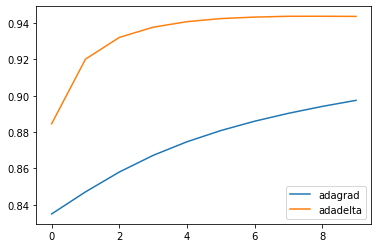

<Figure size 432x288 with 0 Axes>

In [115]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()
plt.savefig('adagrad_adadelta.png') # Adadelta doesn't care about learning rate because it will learn it by itself.

In [149]:
epochs = 10


adagrad_model2 = LightFM(no_components=10,
                        loss='warp',
                        learning_schedule='adagrad')
adadelta_model2 = LightFM(no_components=10,
                        loss='warp',
                        learning_schedule='adadelta')

adagrad_auc2 = []

for epoch in range(epochs):
    adagrad_model2.fit_partial(X_train, epochs=1)
    adagrad_auc2.append(lightfm_auc_score(adagrad_model2, X_test).mean())
    
    
adadelta_auc2 = []

for epoch in range(epochs):
    adadelta_model2.fit_partial(X_train, epochs=1)
    adadelta_auc2.append(lightfm_auc_score(adadelta_model2, X_test).mean())

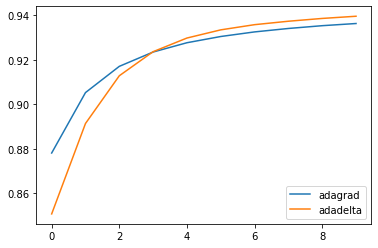

<Figure size 432x288 with 0 Axes>

In [151]:
x = np.arange(len(adagrad_auc2))
plt.plot(x, np.array(adagrad_auc2))
plt.plot(x, np.array(adadelta_auc2))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()
plt.savefig('adagrad_adadelta2.png')


In [ ]:
cv_train_aucs = []
cv_test_aucs = []
for i in range(5):
    cv_X_train, cv_X_test =random_train_test_split(users_artists_sparse, test_percentage=.2)
    cv_model = LightFM(no_components=10,loss='warp',learning_schedule='adadelta', learning_rate=.01)
    cv_model.fit(cv_X_train, epochs=10, num_threads=2)
    cv_train_aucs.append(lightfm_auc_score(cv_model,X_train).mean())
    cv_test_aucs.append(lightfm_auc_score(cv_model, X_test,train_interactions=X_train).mean())



In [119]:
data = {'train_aucs':cv_train_aucs,
        'test_aucs':cv_test_aucs
        }
results = pd.DataFrame(data)
results

,train_aucs,test_aucs
0,0.953705,0.958052
1,0.953410,0.957681
2,0.952799,0.957369
3,0.952807,0.957207
4,0.953008,0.957335


In [116]:
tuned_collab_model = LightFM(no_components=10,learning_rate=.01,learning_schedule='adadelta',loss = 'warp') # Using Stochastic Gradient Descent, which optimizes parameters until it converges
tuned_collab_model.fit(X_train,epochs=10,num_threads=4, verbose=True)
tuned_collab_train_auc = lightfm_auc_score(tuned_collab_model, X_train).mean()
tuned_collab_test_auc = lightfm_auc_score(tuned_collab_model, X_test, train_interactions=X_train).mean()
print("Train auc: %.4f"% tuned_collab_train_auc)
print("Test auc: %.4f"% tuned_collab_test_auc)


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Train auc: 0.9589
Test auc: 0.9427


In [119]:
print("Train precision: %.4f" % precision_at_k(tuned_collab_model, X_train, k=5,num_threads=4).mean())
print("Test precision: %.4f" % precision_at_k(tuned_collab_model, X_test,train_interactions=X_train,\
                                              k=5,num_threads=4).mean())

Train precision: 0.3526
Test precision: 0.1358


Precision_at_k score represents whether the recommended artists are within in the top k list.
AUC score represents the probability that any known positive is higher on the list than a random negative example.

In [405]:
def hybrid_light_fm_recommendation(model, data, user_ids,item_features_sparse):
    """ By using Light FM model, the function
        Data has to be pivoted as n_users x n_items matrix, value = user's play counts.
        num_threads = 4
    parameters:
    
    model- constructed from LightFM
    
    data - the pivoted matrix as n_users x n_items and value = user's play counts
    
    user_ids - user ids to get recommendations
    
    item_features_sparse - sparsed data of artists vs genres
    
    returns:
    Recommended Artists 
    
    """
    n_users, n_items = data.shape
    pid_array = np.array(n_items, dtype=np.int32)
    for user_id in user_ids:
        # artists they already played sorted values by decreasing order
        known_played = get_users_artists(user_id)
        id_index = np.where(data.index==user_id)
        # artists that our model predicts users will like
        scores = model.predict(id_index, np.arange(n_items),\
                               item_features=item_features_sparse,num_threads=2)
        # sort scores in order of mostly liked to leastly liked
        top_items = data.columns[np.argsort(-scores)].tolist()
        #print out the results
        print("User %s" % user_id)
        print("     Top 5 Mostly Played:")
    
        for x in known_played[:5].artist_name:
            print("        '{0}'| '{1}' ".format(x,cleaned_genres.loc[x].genre))

        print("     Top 5 Recommended Artists:")

        for x in top_items[:5]:
            print("        '{0}'| '{1}' ".format(x, cleaned_genres.loc[x].genre))

In [406]:
no_comp, ep = 10,10
tfidf_model = LightFM(no_components=no_comp, learning_schedule='adadelta',loss='warp')
tfidf_model.fit_partial(X_train,
                        item_features=artists_genres_matrix_sparse,
                        epochs=ep,
                        num_threads=2,
                        verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [407]:
tfidf_train_auc = lightfm_auc_score(tfidf_model, X_train, item_features=artists_genres_matrix_sparse).mean()
tfidf_test_auc = lightfm_auc_score(tfidf_model, X_test, train_interactions=X_train, 
                           item_features=artists_genres_matrix_sparse).mean()
print("TfidfVectorizer Train AUC: %.4f" % tfidf_train_auc)
print("TfidfVectorizer Test AUC: %.4f" % tfidf_test_auc)


TfidfVectorizer Train AUC: 0.8257
TfidfVectorizer Test AUC: 0.7329


In [126]:
print("TfidfVectorizer Train precision: %.4f" % precision_at_k(tfidf_model, X_train,\
                                                               item_features=artists_genres_matrix_sparse,
                                                               k=10,num_threads=2).mean())

print("TfidfVectorier Test precision: %.4f" % precision_at_k(tfidf_model, X_test,\
                                                             item_features=artists_genres_matrix_sparse,
                                                             train_interactions=X_train,k=10,num_threads=2).mean())

TfidfVectorizer Train precision: 0.1134
TfidfVectorier Test precision: 0.0299


In [127]:
no_comp, ep = 10, 10 
cf_model = LightFM(no_components=no_comp, learning_schedule='adadelta', loss='warp')
cf_model.fit_partial(X_train,item_features=cf_artists_genres_matrix_sparse,epochs=ep,num_threads=2,verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [128]:
cf_train_auc = lightfm_auc_score(cf_model, X_train,item_features=cf_artists_genres_matrix_sparse).mean()
cf_test_auc = lightfm_auc_score(cf_model, X_test, train_interactions=X_train, item_features=cf_artists_genres_matrix_sparse).mean()
print("Countvectorizer Train AUC: %.4f" % cf_train_auc)
print("Countvectorizer Test AUC: %.4f" % cf_test_auc)

Countvectorizer Train AUC: 0.8223
Countvectorizer Test AUC: 0.7272


In [408]:
hybrid_light_fm_recommendation(tfidf_model, users_artists_pivoted,[4,11,19], artists_genres_matrix_sparse)

User 4
     Top 5 Mostly Played:
        'devendra banhart'| 'chamber pop, folk-pop, freak folk, indie folk, indie pop' 
        'boards of canada'| 'ambient, big beat, electronic, fourth world, intelligent dance music, microhouse, trip hop' 
        'cocorosie'| 'art pop, chamber pop, folktronica, freak folk, new rave, new weird america' 
        'aphex twin'| 'ambient, electronic, intelligent dance music, trip hop' 
        'animal collective'| 'alternative rock, art pop, baltimore indie, chamber pop, chillwave, dance-punk, dream pop, experimental pop, experimental rock, folk-pop, freak folk, indie folk, indie pop, indie rock, indietronica, lo-fi, modern rock, new rave, noise pop, noise rock, nu gaze' 
     Top 5 Recommended Artists:
        'the jon spencer blues explosion'| 'blues-rock, garage rock, punk blues' 
        'red hot chili peppers'| 'alternative rock, funk metal, permanent wave, post-grunge, rock' 
        'green day'| 'permanent wave, pop punk, punk, rock' 
        'pi

In [131]:
hybrid_light_fm_recommendation(cf_model, users_artists_pivoted,[4,11,19],cf_artists_genres_matrix_sparse)

User 4
     Top 5 Mostly Played:
        'devendra banhart'| 'chamber pop, folk-pop, freak folk, indie folk, indie pop' 
        'boards of canada'| 'ambient, big beat, electronic, fourth world, intelligent dance music, microhouse, trip hop' 
        'cocorosie'| 'art pop, chamber pop, folktronica, freak folk, new rave, new weird america' 
        'aphex twin'| 'ambient, electronic, intelligent dance music, trip hop' 
        'animal collective'| 'alternative rock, art pop, baltimore indie, chamber pop, chillwave, dance-punk, dream pop, experimental pop, experimental rock, folk-pop, freak folk, indie folk, indie pop, indie rock, indietronica, lo-fi, modern rock, new rave, noise pop, noise rock, nu gaze' 
     Top 5 Recommended Artists:
        'kanye west'| 'chicago rap, pop rap, rap' 
        'tom waits'| 'folk, folk rock, folk-pop, roots rock, singer-songwriter' 
        'nightmares on wax'| 'acid jazz, downtempo, electronic, nu jazz, trip hop, turntablism' 
        'johnny cash'| 'o

## Implicit Alternating Least Squares
Leave One Out Cross Validation
We compute Top N recommendations for each user in our trainning data and intentionally remove
one of those items from that user's trainning data.
Then we then test our recommender system's ability to figure the item that was left out in the Top N result.
This algorithm is a user focused task since we have an implicit data, which indirectly reflect opinion through
observing user behavior.
Hence, we will have to split the dataset into trainning and test in other new ways, not the regular splitting.

In [132]:
users_artists_sparse
# 61340 users and 3647 artists

<61340x3647 sparse matrix of type '<class 'numpy.int64'>'
	with 1576182 stored elements in Compressed Sparse Row format>

In [133]:
matrix_size = users_artists_sparse.shape[0]*users_artists_sparse.shape[1] # Number of possible interactions in the matrix
num_artists_listened = len(users_artists_sparse.nonzero()[0]) # Number of artists interacted with 
sparsity = 100*(1 - (num_artists_listened/matrix_size))
sparsity

99.29542565010712

MF methods are designed to get over the problem of sparsity and therefore can possibly work even with such a sparse data set. our sparsity is nice to work with for MF(Matrix Factorization).

In [134]:
def train_split(ratings, pct_test=.20):
    """
        This function takes rating values(sparsed data) to change zero values for a certain percentage of the training set.
        So that we can figure out that model noticed the changed values from the training set.
        Test Set will be the same as the original data set, which here is a sparse matrix.
        Test Set is used for comparing the changed values.
        
        parameters:
        ratings - users_artists_sparsed data with value of count of plays for each artists
    """
    random.seed(0) # Set the random seed to zero for reproducibility.
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Set as binary matrix, where 1 indicates user played artists.
    training_set = ratings.copy() # We will alter pct_test of the training_set.
    nonzero_inds = training_set.nonzero() # Find the indices of (users, artists) intersection.
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip the pairs of (user,item) indices into list.
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Numer of samples.
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of (user,item) intersection without replacement
    user_inds = [index[0] for index in samples] # The user row indices.
    artist_inds = [index[1] for index in samples] # The item column indices.
    training_set[user_inds, artist_inds] = 0 # Assign all of the randomly chosen user-artist pairs to zero (not played).
    training_set.eliminate_zeros() # Remove zero entries from the matrix to save memory. 

    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  

In [156]:
als_X_train, als_X_test, users_changed = train_split(users_artists_sparse) 

In [143]:
def rmse (predictions, actual):
    """
    This function will return to rmse score
    
    parameters:
    predictions - prediction output
    actual - actual
    """
    return np.sqrt(mean_squared_error(actual, predictions))

In [136]:
def auc_score(predictions, actual):
    '''
    This function will return to (area under the Receiver Operating Characterisic curve) score
    
    parameters:
    
    predictions - your prediction output
    
    test- comparing variable
    
    '''
    fpr, tpr, thresholds = metrics.roc_curve(actual, predictions)
    return metrics.auc(fpr, tpr)   

In [161]:
csr_matrix(artist_factors)

<61340x20 sparse matrix of type '<class 'numpy.float32'>'
	with 1217820 stored elements in Compressed Sparse Row format>

In [203]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set constructed from make_train, where 20 percent of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted countings for each user/artists pair as output 
    from the implicit matrix factorization.
    Stored in a list. predictions[0] with user vectors as artist and predictions[1] artist vectors as artist one. 
    
    altered_users - The indices of the users where at least one user/artist pair was changed from make_train function
    
    test_set - The test set constucted from make_train function
    
    returns:
    
    The mean AUC of the test set only on user-item interactions.
    There were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    auc = [] # AUC for each user that had an item removed from the training set
    pop_auc = [] # To store popular AUC scores
    rmses = []
    pop_items = np.array(test_set.sum(axis = 0)).flatten() # Get sum of artist iteractions to find most popular artist.
    artist_vecs = predictions[1]
    
    for user in altered_users: # Iterate through each row(user) that had an artist altered
        training_row = training_set[user,:].toarray().flatten() # Get trainning set in flatten array.
        zero_inds = np.where(training_row == 0) # Find where the interaction of users did not happen.
        user_vec = predictions[0][user,:] # Get the predicted values based on our user/artists vectors
        
        pred = user_vec.dot(artist_vecs).toarray()[0,zero_inds].flatten()
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for dthis user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].flatten()
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        
        pop = pop_items[zero_inds] # Get the popularity for our chosen artist.
        auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        pop_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular artist and score
        rmses.append(rmse(pred,actual))
    return float('%.3f'%np.mean(auc)), float('%.3f'%np.mean(pop_auc)), float('%3.f'%np.mean(rmses))
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

To fit ALS, the matrix of confidences for the liked items should be a csr_matrix where the rows of the matrix are the item, the columns are the users that liked that item, and the value is the confidence that the user liked the item.
So I had to transpose Train Set

In [172]:
implicit_ALS = implicit.als.AlternatingLeastSquares(factors=20,regularization = 0.1, iterations = 50)
# With 20 latent factors.
implicit_ALS.fit((als_X_train.T*15).astype('float'))


100%|██████████| 50.0/50 [00:09<00:00,  6.20it/s]


In [167]:
implicit_ALS.user_factors.shape

(3647, 20)

In [416]:
als_X_train

<61340x3647 sparse matrix of type '<class 'numpy.int64'>'
	with 1260945 stored elements in Compressed Sparse Row format>

In [173]:
user_factors = implicit_ALS.user_factors
artist_factors = implicit_ALS.item_factors

In [204]:
calc_mean_auc(als_X_train, users_changed, 
              [csr_matrix(user_factors), csr_matrix(artist_factors.T)], als_X_test)

(0.927, 0.839, 0.0)

In [509]:
def get_ALS_n_recommend(user_ids, data, als_train,csr_user_factors,csr_artist_factors,N=10):     
    
    for user_id in user_ids:
        id_index = np.where(data.index == user_id)
        pref_artists = als_train[id_index].toarray() # Get played Artists
        pref_artists= pref_artists + 1 # Set not yet listened artists as 1 
        pref_artists[pref_artists > 1] = 0 # Set listened artists as 0
        scores = csr_user_factors[id_index].dot(csr_artist_factors).toarray().flatten()
        
        top_items = data.columns[np.argsort(-scores)].tolist()
        print("User %s" % user_id)
        print("     Top 5 Recommended Artists:")

        for x in top_items[:5]:
            print("        '{0}' ".format(x))
            

In [511]:
get_ALS_n_recommend([4,11,15,19],
                    users_artists_pivoted,
                    als_X_train,
                    csr_matrix(user_factors), 
                    csr_matrix(artist_factors.T), 
                    N=10)

User 4
     Top 5 Recommended Artists:
        'the avalanches' 
        'blockhead' 
        'dntel' 
        'thom yorke' 
        'röyksopp' 
User 11
     Top 5 Recommended Artists:
        'cyndi lauper' 
        'carpenters' 
        'stevie nicks' 
        'chris isaak' 
        'pat benatar' 
User 15
     Top 5 Recommended Artists:
        'manchester orchestra' 
        'northstar' 
        'dear and the headlights' 
        'the early november' 
        'limbeck' 
User 19
     Top 5 Recommended Artists:
        'cradle of filth' 
        'manowar' 
        'korpiklaani' 
        'katatonia' 
        'dimmu borgir' 
